# DSA3101: Customer Segmentation by K-Means Clustering

Our group is a Data Science Consulting Company which has been approached by a client, which would like us to reach some insights that might help them make better business decisions by analysing their data.

Three sets of data were given to the Data Science Consulting Company in hopes of deriving the appropriate insights about customer purchasing behaviour and devising the corresponding strategies to increase customer retention and maximise its profit. 

Looking at the data given, it seems as if the company being analysed is a grocery chain which sells a wide range of products. As such, a customer was defined according to the usual expected behaviour of customers in a grocery store.



**Contents:**
- Import Libraries
- Import Datasets
- Data Cleaning
- Exploratory Data Analysis
- K-Means Clustering on the Percentage Spend of Each Product Type
- Exploratory Data Analysis with 5 Clusters
- Actionable Insights
- Conclusion

<a id='lib_imports'></a>

## Import Libraries

In [ ]:
!pip install kneed
import matplotlib.pyplot as plt                   
import pandas as pd                               
import numpy as np                                
import seaborn as sns
import os
import urllib
from sklearn.cluster import KMeans #Do K-Means clustering
from sklearn.metrics import silhouette_score #Calculate score of silhouette for each K
from sklearn.preprocessing import StandardScaler #Install sklearn
from kneed import KneeLocator #Install #Find the knee of the WCSS vs K plot
from yellowbrick.cluster import SilhouetteVisualizer #Plot Silhouette plot
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from decimal import Decimal
from functools import reduce
%matplotlib inline

<a id='data_imports'></a>

## Import Datasets

In [ ]:
# import datasets
datapath = os.path.join("datasets", "")
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/leongjwm/dsa3101_hackathon/master/"
os.makedirs(datapath, exist_ok=True)
for filename in ("DSA3101_Hackathon_Categories_Information.csv", "DSA3101_Hackathon_Data.csv", "DSA3101_Hackathon_Panelists_Demographics.xlsx"):
    print("Downloading", filename)
    url = DOWNLOAD_ROOT + "datasets/" + filename
    urllib.request.urlretrieve(url, datapath + filename)

In [ ]:
transactions = pd.read_csv(datapath + "DSA3101_Hackathon_Data.csv") # customer transactions
categories = pd.read_csv(datapath + "DSA3101_Hackathon_Categories_Information.csv") # product categories
demographics = pd.read_excel(datapath + "DSA3101_Hackathon_Panelists_Demographics.xlsx") # customer information

In [ ]:
transactions.head()

,Panel ID,Date,Category,Pack Size,Volume,Spend
0,Panel 101011101,2017-07-02,CSD,1,1.5,1.5
1,Panel 101011101,2017-07-02,Soy Milk,1,1.0,2.8
2,Panel 101011101,2017-07-02,Cooking Sauces,1,0.3,3.2
3,Panel 101011101,2017-07-02,Coconut Milk,2,0.4,5.3
4,Panel 101011101,2017-07-02,Chocolate,1,0.2,6.6


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318024 entries, 0 to 1318023
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   Panel ID   1318024 non-null  object 
 1   Date       1318024 non-null  object 
 2   Category   1318024 non-null  object 
 3   Pack Size  1318024 non-null  int64  
 4   Volume     1318024 non-null  float64
 5   Spend      1318024 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 60.3+ MB


We note that the `Date` values have the `object` datatype, so we should convert them to the `datetime` datatype.

In [ ]:
transactions['Date'] = pd.to_datetime(transactions['Date'], format = "%Y-%m-%d")
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1318024 entries, 0 to 1318023
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   Panel ID   1318024 non-null  object        
 1   Date       1318024 non-null  datetime64[ns]
 2   Category   1318024 non-null  object        
 3   Pack Size  1318024 non-null  int64         
 4   Volume     1318024 non-null  float64       
 5   Spend      1318024 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 60.3+ MB


In [ ]:
categories.head()

,Category,Calories/100g,Price per Volume
0,Baby Cereal,188,29.41
1,Beer,43,15.12
2,Belacan,563,39.47
3,Bird Nest,46,73.45
4,Biscuits,416,15.57


In [ ]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Category          62 non-null     object 
 1   Calories/100g     62 non-null     int64  
 2   Price per Volume  62 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.6+ KB


In [ ]:
categories['Category'].unique()

array(['Baby Cereal', 'Beer', 'Belacan', 'Bird Nest', 'Biscuits',
       'Bouilon', 'Butter', 'Cake', 'Canned Product', 'Cereal Beverage',
       'Cereals', 'Cheese', 'Chicken Essence', 'Choc/Nut Spread',
       'Chocolate', 'Coconut Milk', 'Coffee', 'Condensed/Evap Milk',
       'Confectionery', 'Cooking Oils', 'Cooking Sauces', 'Cordials',
       'Creamer', 'CSD', 'Cultured Milk', 'Drinking Water', 'Eggs',
       'Energy Drinks', 'Flour', 'Frozen Food', 'Fruit/Veg Juices',
       'Ghee', 'Honey', 'Ice Cream', 'Instant Noodles', 'Instant Soup',
       'Isotonic Drinks', 'Jam', 'Kaya', 'Liquid Milk', 'Margarine',
       'Milk Powder-Adult', 'Milk Powder-Infant', 'Milk Powder-Kids',
       'MSG', 'Peanut Butter', 'Rice', 'RTD Coffee', 'RTD Tea',
       'Salad Dressing', 'Savoury Spread', 'Seasoning Powder', 'Snack',
       'Soy Milk', 'Spagetti', 'Spirits', 'Sugar', 'Tea',
       'Tonic Food Drink', 'Wine', 'Yoghurt Drink', 'Yoghurts'],
      dtype=object)

In [ ]:
beverages = ['CSD', 'Tonic Food Drink', 'Coffee', 'Isotonic Drinks', 'Cordials', 'Creamer', 'Soy Milk', 'RTD Coffee', 'RTD Tea',
            'Tea', 'Fruit/Veg Juices', 'Yoghurt Drink', 'Cultured Milk', 'Drinking Water', 'Beer', 'Energy Drinks', 'Spirits', 'Wine']

babyCare = ['Baby Cereal', 'Milk Powder-Infant']

packagedFood = ['Canned Product', 'Frozen Food', 'Ice Cream', 'Cake', 'Biscuits', 'Instant Noodles', 'Chocolate', 'Snack',
                'Spagetti', 'Instant Soup', 'Confectionery', 'Yoghurts']

stapleGoods = ['Rice', 'Liquid Milk', 'Eggs', 'Cereals', 'Cereal Beverage', 'Milk Powder-Adult', 'Milk Powder-Kids']

cookingEssentials = ['Seasoning Powder', 'Cooking Oils', 'Coconut Milk', 'Cooking Sauces', 'Bouilon', 'Belacan',
                      'Condensed/Evap Milk', 'Ghee', 'Honey', 'MSG']

bakingOrSpreads = ['Kaya', 'Margarine', 'Flour', 'Sugar', 'Peanut Butter', 'Salad Dressing', 'Jam', 'Savoury Spread', 
                   'Butter', 'Choc/Nut Spread', 'Cheese']

otherProducts = ['Chicken Essence', 'Bird Nest']

In [ ]:
def classify_product(x):
  if x in beverages:
    return 'Beverages'
  elif x in babyCare:
    return 'Baby Care'
  elif x in packagedFood:
    return 'Packaged Food'
  elif x in stapleGoods:
    return 'Staple Goods'
  elif x in cookingEssentials:
    return 'Cooking Essentials'
  elif x in bakingOrSpreads:
    return 'Baking Products/Spreads'
  elif x in otherProducts:
    return 'Other Products'

In [ ]:
categories['Product Type'] = categories['Category'].apply(classify_product)

In [ ]:
categories.head()

,Category,Calories/100g,Price per Volume,Product Type
0,Baby Cereal,188,29.41,Baby Care
1,Beer,43,15.12,Beverages
2,Belacan,563,39.47,Cooking Essentials
3,Bird Nest,46,73.45,Other Products
4,Biscuits,416,15.57,Packaged Food


In [ ]:
demographics.head()

,ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,Obese,Income 1500 - 1999,North Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,Healthy,Income 1500 - 1999,North Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,Obese,Income < 1500,North Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,Over Weight,Income 1500 - 1999,North Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,Over Weight,Income < 1500,North Malay,Empty Nesters,Rural,1-3 Member HH,North


In [ ]:
demographics.rename(columns={"ID" : "Panel ID"}, inplace=True)
demographics.replace({'North Malay': 'Malay', 'North Chinese': 'Chinese', 'North Others': 'Others', 'South Malay': 'Malay', 'Central Malay': 'Malay', 'Central Others': 'Others', 'Central Chinese': 'Chinese', 'South Chinese': 'Chinese', 'South Others': 'Others', 'East Coast Malay': 'Malay', 'East Coast Chinese': 'Chinese', 'East Coast Others': 'Others'}, inplace=True)
demographics.head()

,Panel ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location
0,Panel 101011101,Obese,Income 1500 - 1999,Malay,Empty Nesters,Urban,1-3 Member HH,North
1,Panel 101016101,Healthy,Income 1500 - 1999,Malay,Teens Aches,Urban,1-3 Member HH,North
2,Panel 101019101,Obese,Income < 1500,Malay,Teens Aches,Urban,4 Member HH,North
3,Panel 101024101,Over Weight,Income 1500 - 1999,Chinese,Nesting Families,Urban,1-3 Member HH,North
4,Panel 105009103,Over Weight,Income < 1500,Malay,Empty Nesters,Rural,1-3 Member HH,North


In [ ]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4026 entries, 0 to 4025
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Panel ID   4026 non-null   object
 1   BMI        4026 non-null   object
 2   Income     4026 non-null   object
 3   Ethnicity  4026 non-null   object
 4   Lifestage  4026 non-null   object
 5   Strata     4026 non-null   object
 6   #HH        4026 non-null   object
 7   location   4026 non-null   object
dtypes: object(8)
memory usage: 251.8+ KB


<a id='data_clean'></a>

## Data Cleaning

We first remove the rows where `Spend` == 0 or (`Pack Size` == 0 and `Volume` == 0) or `Pack Size` == 0, then remove rows where transactions were 2 years before the most recent transaction date.

In [ ]:
# Remove rows with Spend == 0
remove_spend0 = transactions.loc[transactions.Spend == 0].index
transactions_clean = transactions.drop(remove_spend0, axis=0)

# Remove rows with Pack Size == 0 and Volume == 0
remove_volPS0 = transactions_clean.loc[(transactions_clean.Volume<=0) & (transactions_clean["Pack Size"]<=0)].index
transactions_clean = transactions_clean.drop(remove_volPS0, axis=0)

# Remove rows with Pack Size == 0
remove_PS0 = transactions_clean.loc[(transactions_clean["Pack Size"]<=0)].index
transactions_clean = transactions_clean.drop(remove_PS0, axis=0)

# Remove rows where transactions were 2 years before latest transaction
print("Latest transaction Date: " + str(transactions['Date'].max())) # 14-06-2020 is the latest transaction date
yearslimit = pd.to_datetime('20180615', format='%Y%m%d')
remove_toolong = transactions_clean.loc[(transactions_clean.Date<=yearslimit)].index

transactions_clean = transactions_clean.drop(remove_toolong, axis=0)
transactions_clean

Latest transaction Date: 2020-06-14 00:00:00


,Panel ID,Date,Category,Pack Size,Volume,Spend
125,Panel 101011101,2018-06-17,Coconut Milk,2,0.4,6.2
126,Panel 101011101,2018-06-17,Condensed/Evap Milk,2,0.8,6.1
127,Panel 101011101,2018-06-17,Condensed/Evap Milk,2,0.8,10.0
128,Panel 101011101,2018-06-24,Coffee,3,0.6,9.6
129,Panel 101011101,2018-07-01,Sugar,5,5.0,13.5
...,...,...,...,...,...,...
1318019,Panel 801912801,2020-02-23,MSG,1,0.1,2.2
1318020,Panel 801912801,2020-02-23,Eggs,1,30.0,8.4
1318021,Panel 801912801,2020-02-23,Ice Cream,1,1.5,8.0
1318022,Panel 801912801,2020-02-23,Cooking Sauces,1,0.7,4.8


In [ ]:
transactions_clean.nunique() #ensure only those who fit the customer definition are inside 

Panel ID     2787
Date          105
Category       62
Pack Size      68
Volume        220
Spend        1879
dtype: int64

<a id='eda'></a>

## Exploratory Data Analysis

We should dive in deeper when examining each customer's data; obtaining more useful numerical variables might help in unsupervised machine learning methods like k-means clustering.

### Aggregation of Each Customer's Data

Finding useful numerical variables such as the total amount each customer had spent on Baby Care Products might facilitate processes such as customer segmentation more easily.

In [ ]:
transWithProducts = transactions_clean.merge(categories, how = 'left', on = 'Category')
transWithProducts

,Panel ID,Date,Category,Pack Size,Volume,Spend,Calories/100g,Price per Volume,Product Type
0,Panel 101011101,2018-06-17,Coconut Milk,2,0.4,6.2,233,11.15,Cooking Essentials
1,Panel 101011101,2018-06-17,Condensed/Evap Milk,2,0.8,6.1,321,4.85,Cooking Essentials
2,Panel 101011101,2018-06-17,Condensed/Evap Milk,2,0.8,10.0,321,4.85,Cooking Essentials
3,Panel 101011101,2018-06-24,Coffee,3,0.6,9.6,1,26.76,Beverages
4,Panel 101011101,2018-07-01,Sugar,5,5.0,13.5,405,2.94,Baking Products/Spreads
...,...,...,...,...,...,...,...,...,...
865130,Panel 801912801,2020-02-23,MSG,1,0.1,2.2,0,19.02,Cooking Essentials
865131,Panel 801912801,2020-02-23,Eggs,1,30.0,8.4,97,0.37,Staple Goods
865132,Panel 801912801,2020-02-23,Ice Cream,1,1.5,8.0,240,10.64,Packaged Food
865133,Panel 801912801,2020-02-23,Cooking Sauces,1,0.7,4.8,175,8.40,Cooking Essentials


In [ ]:
# Total Spend on each product by each customer over the 2 years
transProductSum = transWithProducts.groupby(['Panel ID', 'Category'])['Spend'].sum().reset_index()
#transProductCount.rename(columns={'Date':'Count'}, inplace=True)
transProductSum = transProductSum.merge(categories[['Category', 'Product Type']], how = 'left', on = 'Category')
transProductSum

,Panel ID,Category,Spend,Product Type
0,Panel 101011101,Biscuits,60.2,Packaged Food
1,Panel 101011101,Bouilon,9.1,Cooking Essentials
2,Panel 101011101,Butter,31.9,Baking Products/Spreads
3,Panel 101011101,CSD,17.5,Beverages
4,Panel 101011101,Cake,5.7,Packaged Food
...,...,...,...,...
80099,Panel 801912801,Ice Cream,8.0,Packaged Food
80100,Panel 801912801,Liquid Milk,7.3,Staple Goods
80101,Panel 801912801,MSG,4.4,Cooking Essentials
80102,Panel 801912801,Rice,53.5,Staple Goods


In [ ]:
# Total Spend on each Product Type by each customer over the 2 years
transProductTypeSum = transProductSum.groupby(['Panel ID', 'Product Type'])['Spend'].sum().reset_index()
transProductTypeSum

,Panel ID,Product Type,Spend
0,Panel 101011101,Baking Products/Spreads,863.2
1,Panel 101011101,Beverages,223.9
2,Panel 101011101,Cooking Essentials,607.5
3,Panel 101011101,Packaged Food,240.3
4,Panel 101011101,Staple Goods,926.2
...,...,...,...
14185,Panel 801912801,Baking Products/Spreads,29.6
14186,Panel 801912801,Beverages,24.9
14187,Panel 801912801,Cooking Essentials,108.7
14188,Panel 801912801,Packaged Food,8.0


In [ ]:
# Total Spend on each Product Type by each customer over the 2 years; stored by Product Type into different dataframes
transBeverage = transProductTypeSum[transProductTypeSum['Product Type'] == 'Beverages']
transBabyCare = transProductTypeSum[transProductTypeSum['Product Type'] == 'Baby Care']
transFood = transProductTypeSum[transProductTypeSum['Product Type'] == 'Packaged Food']
transStaple = transProductTypeSum[transProductTypeSum['Product Type'] == 'Staple Goods']
transCooking = transProductTypeSum[transProductTypeSum['Product Type'] == 'Cooking Essentials']
transBaking = transProductTypeSum[transProductTypeSum['Product Type'] == 'Baking Products/Spreads']
transOther = transProductTypeSum[transProductTypeSum['Product Type'] == 'Other Products']
transBeverage

,Panel ID,Product Type,Spend
1,Panel 101011101,Beverages,223.9
6,Panel 101016101,Beverages,101.8
11,Panel 101019101,Beverages,1714.8
16,Panel 101024101,Beverages,973.7
21,Panel 105009103,Beverages,886.5
...,...,...,...
14166,Panel 801900701,Beverages,37.9
14171,Panel 801901201,Beverages,99.8
14176,Panel 801903201,Beverages,99.6
14181,Panel 801903801,Beverages,74.5


In [ ]:
# Total Spend of each customer over the 2 years
transSum = transWithProducts.groupby(['Panel ID'])['Spend'].sum().reset_index()
#transCount.rename(columns={'Date':'Total'}, inplace=True)
transSum

,Panel ID,Spend
0,Panel 101011101,2861.1
1,Panel 101016101,1224.6
2,Panel 101019101,5212.8
3,Panel 101024101,3960.7
4,Panel 105009103,3120.9
...,...,...
2782,Panel 801900701,213.1
2783,Panel 801901201,1165.0
2784,Panel 801903201,400.0
2785,Panel 801903801,278.6


In [ ]:
transfinal = transSum.copy() # to get just the absolute values of the spendings per category
transfinal = transfinal.merge(transBeverage[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend_x':'Total Spend','Spend_y':'Beverage'}, inplace=True)
transfinal = transfinal.merge(transBabyCare[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend':'BabyCare'}, inplace=True)
transfinal = transfinal.merge(transFood[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend':'PackagedFood'}, inplace=True)
transfinal = transfinal.merge(transStaple[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend':'StapleGoods'}, inplace=True)
transfinal = transfinal.merge(transCooking[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend':'CookingEssentials'}, inplace=True)
transfinal = transfinal.merge(transBaking[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend':'BakingAndSpreads'}, inplace=True)
transfinal = transfinal.merge(transOther[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transfinal.rename(columns={'Spend':'OtherProducts'}, inplace=True)
transfinal.fillna(0.0, inplace=True)
transfinal.drop(columns='Panel ID').values

array([[2.8611e+03, 2.2390e+02, 0.0000e+00, ..., 6.0750e+02, 8.6320e+02,
        0.0000e+00],
       [1.2246e+03, 1.0180e+02, 0.0000e+00, ..., 3.8530e+02, 1.9050e+02,
        0.0000e+00],
       [5.2128e+03, 1.7148e+03, 0.0000e+00, ..., 7.9260e+02, 5.8510e+02,
        0.0000e+00],
       ...,
       [4.0000e+02, 9.9600e+01, 0.0000e+00, ..., 4.3300e+01, 5.2000e+00,
        0.0000e+00],
       [2.7860e+02, 7.4500e+01, 0.0000e+00, ..., 2.4700e+01, 6.6000e+00,
        0.0000e+00],
       [2.6430e+02, 2.4900e+01, 0.0000e+00, ..., 1.0870e+02, 2.9600e+01,
        0.0000e+00]])

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(transfinal.drop(columns=['Panel ID', 'Total Spend']).values)
scaled_pattern_df = pd.DataFrame(scaled_features, index=transfinal.drop(columns=['Panel ID', 'Total Spend']).index, columns=transfinal.drop(columns=['Panel ID', 'Total Spend']).columns)

scaled_pattern_df.corr()

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Beverage,1.000000,0.020414,0.592844,0.403588,0.482955,0.474829,0.295836
BabyCare,0.020414,1.000000,0.051780,0.194302,0.045525,0.021776,0.002963
PackagedFood,0.592844,0.051780,1.000000,0.499333,0.535168,0.578004,0.202308
StapleGoods,0.403588,0.194302,0.499333,1.000000,0.559292,0.512963,0.154004
CookingEssentials,0.482955,0.045525,0.535168,0.559292,1.000000,0.725824,0.090856
BakingAndSpreads,0.474829,0.021776,0.578004,0.512963,0.725824,1.000000,0.151394
OtherProducts,0.295836,0.002963,0.202308,0.154004,0.090856,0.151394,1.000000


In [ ]:
pip install factor_analyzer

     |████████████████████████████████| 40kB 1.9MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp36-none-any.whl size=40382 sha256=3a4d4fd38e1c22f3313f92dc2ce604c43d305a455c2fe5b52580b9f69d2191cc
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


In [ ]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

In [ ]:
transProductPerc = transSum.copy()
transProductPerc = transProductPerc.merge(transBeverage[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend_x':'Total Spend','Spend_y':'Beverage'}, inplace=True)
transProductPerc = transProductPerc.merge(transBabyCare[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend':'BabyCare'}, inplace=True)
transProductPerc = transProductPerc.merge(transFood[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend':'PackagedFood'}, inplace=True)
transProductPerc = transProductPerc.merge(transStaple[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend':'StapleGoods'}, inplace=True)
transProductPerc = transProductPerc.merge(transCooking[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend':'CookingEssentials'}, inplace=True)
transProductPerc = transProductPerc.merge(transBaking[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend':'BakingAndSpreads'}, inplace=True)
transProductPerc = transProductPerc.merge(transOther[['Panel ID', 'Spend']], how = 'left', on = 'Panel ID')
transProductPerc.rename(columns={'Spend':'OtherProducts'}, inplace=True)
transProductPerc.fillna(0.0, inplace=True)
transProductPerc

,Panel ID,Total Spend,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
0,Panel 101011101,2861.1,223.9,0.0,240.3,926.2,607.5,863.2,0.0
1,Panel 101016101,1224.6,101.8,0.0,55.5,491.5,385.3,190.5,0.0
2,Panel 101019101,5212.8,1714.8,0.0,505.2,1615.1,792.6,585.1,0.0
3,Panel 101024101,3960.7,973.7,0.0,1824.5,649.0,308.4,205.1,0.0
4,Panel 105009103,3120.9,886.5,0.0,542.9,836.0,830.6,24.9,0.0
...,...,...,...,...,...,...,...,...,...
2782,Panel 801900701,213.1,37.9,0.0,28.4,92.1,53.3,1.4,0.0
2783,Panel 801901201,1165.0,99.8,0.0,321.3,475.0,180.1,88.8,0.0
2784,Panel 801903201,400.0,99.6,0.0,107.6,144.3,43.3,5.2,0.0
2785,Panel 801903801,278.6,74.5,0.0,129.1,43.7,24.7,6.6,0.0


In [ ]:
# (Unused)
# Note: To not run more than once (to avoid changing the percentages)
# transProductPerc['%Beverage'] = transProductPerc['%Beverage'] * 100 / transProductPerc['Total Spend']
# transProductPerc['%BabyCare'] = transProductPerc['%BabyCare'] * 100 / transProductPerc['Total Spend']
# transProductPerc['%StapleGoods'] = transProductPerc['%StapleGoods'] * 100 / transProductPerc['Total Spend']
# transProductPerc['%CookingEssentials'] = transProductPerc['%CookingEssentials'] * 100 / transProductPerc['Total Spend']
# transProductPerc['%BakingAndSpreads'] = transProductPerc['%BakingAndSpreads'] * 100 / transProductPerc['Total Spend']
# transProductPerc['%PackagedFood'] = transProductPerc['%PackagedFood'] * 100 / transProductPerc['Total Spend']
# transProductPerc['%OtherProducts'] = transProductPerc['%OtherProducts'] * 100 / transProductPerc['Total Spend']

In [ ]:
# transProductPerc

## K-Means Clustering on the Percentage Spend of Each Product Type

Using the proportion of how much each customer spent on each Product Type, clustering similar purchase patterns into the same group might help us to understand what customers of specific demographics might want and therefore allows us to propose clear solutions for both the client's and customers' benefit, such as which product(s) to recommend to certain groups of customers.  

### Unscaled Data

In [ ]:
# kmeans on the absolute spending on product categories 
kmeanstransfinal = transfinal[['Beverage', 'BabyCare', 'PackagedFood', 'StapleGoods', 'CookingEssentials', 'BakingAndSpreads', 'OtherProducts']].to_numpy()
kmeanstransfinal

array([[ 223.9,    0. ,  240.3, ...,  607.5,  863.2,    0. ],
       [ 101.8,    0. ,   55.5, ...,  385.3,  190.5,    0. ],
       [1714.8,    0. ,  505.2, ...,  792.6,  585.1,    0. ],
       ...,
       [  99.6,    0. ,  107.6, ...,   43.3,    5.2,    0. ],
       [  74.5,    0. ,  129.1, ...,   24.7,    6.6,    0. ],
       [  24.9,    0. ,    8. , ...,  108.7,   29.6,    0. ]])

In [ ]:
# kmeans on the absolute spending on product categories 
wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans_transfinal = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_transfinal.fit(kmeanstransfinal)
    wcss.append(kmeans_transfinal.inertia_)

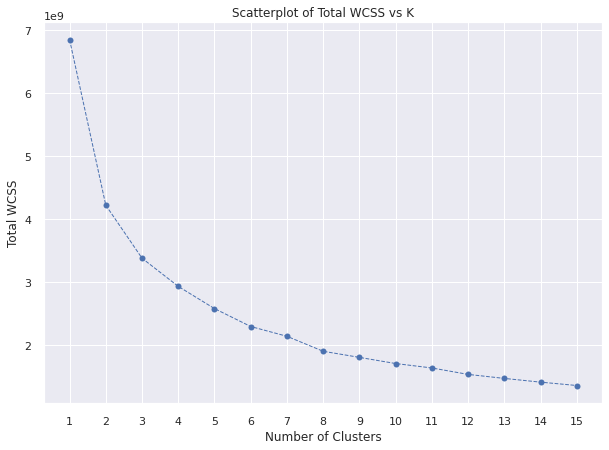

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
k0 = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

k0.elbow

#To locate the elbow point of the curve using kneed package

4

In [ ]:
# silhouette analysis on the absolute spending on product categories 
# A list holds the silhouette coefficients for each k
silhouette_coefficients1 = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(kmeanstransfinal)
    score = silhouette_score(kmeanstransfinal, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients1.append(score)

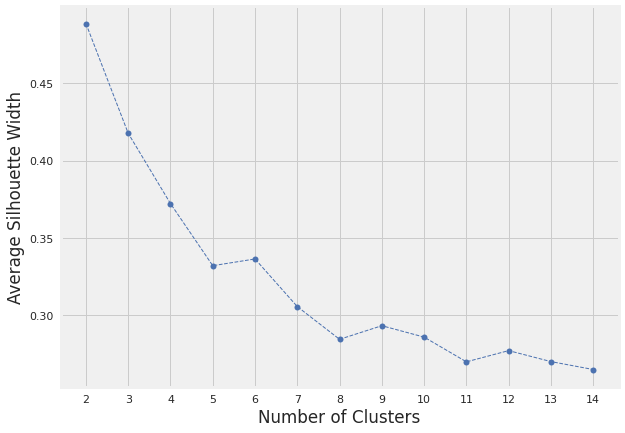

In [ ]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients1,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

### K = 2 for K-Means Clustering of Customers According to Spends of Product Types (Unscaled)

In [ ]:
# k = 2 on absolute spending 
kmeans_transfinal = KMeans(init="random",n_clusters=2 , n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal.fit(kmeanstransfinal)
clustergroups_transfinal = kmeans_transfinal.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal = pd.DataFrame(kmeans_transfinal.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal.index.name = "Clusters"

In [ ]:
test0 = pd.Series(clustergroups_transfinal)
test0.value_counts()

1    2061
0     726
dtype: int64

In [ ]:
Clustercenters_transfinal

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,1064.708528,93.801788,1355.949794,2320.707153,925.414443,467.166713,33.193398
1,303.258495,30.392136,363.780194,631.009417,319.453301,159.494854,8.070340


### K = 3 for K-Means Clustering of Customers According to Spends of Product Types (Unscaled)


In [ ]:
# k = 3 on absolute spending 
kmeans_transfinal = KMeans(init="random",n_clusters=3 , n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal.fit(kmeanstransfinal)
clustergroups_transfinal = kmeans_transfinal.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal = pd.DataFrame(kmeans_transfinal.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal.index.name = "Clusters"

In [ ]:
test0 = pd.Series(clustergroups_transfinal)
test0.value_counts()

0    1677
2     976
1     134
dtype: int64

In [ ]:
Clustercenters_transfinal

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,235.283831,26.557458,275.635024,491.708413,250.081384,125.455131,6.841169
1,1636.564925,216.853731,1742.479851,4245.622388,1193.384328,590.154478,74.520896
2,803.603071,58.580348,1064.182293,1631.542272,769.498669,387.764688,19.759365


### K = 4 for K-Means Clustering of Customers According to Spends of Product Types (Unscaled)

In [ ]:
# k = 4 on absolute spending 
kmeans_transfinal = KMeans(init="random",n_clusters=4 , n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal.fit(kmeanstransfinal)
clustergroups_transfinal = kmeans_transfinal.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal = pd.DataFrame(kmeans_transfinal.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal.index.name = "Clusters"

In [ ]:
test0 = pd.Series(clustergroups_transfinal)
test0.value_counts()

1    1426
0    1006
3     268
2      87
dtype: int64

In [ ]:
Clustercenters_transfinal

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,603.045427,61.839563,738.743340,1439.014414,651.376640,319.478231,16.025348
1,198.198247,24.395582,240.918794,397.456592,205.636886,103.822791,6.427209
2,1059.048276,215.840230,1295.216092,4953.766667,963.285057,478.045977,71.101149
3,1557.179104,56.063060,1999.077985,2021.023134,1113.885075,586.392537,34.641791


### K-Means Clustering with Scaled Data

In [ ]:
# kmeans with scaled data on absolute spending 
scaler = StandardScaler()
kmeanstransfinal_scaled = scaler.fit_transform(kmeanstransfinal)

In [ ]:
kmeanstransfinal_scaled

array([[-0.39839108, -0.19298067, -0.55270428, ...,  0.27424031,
         2.42348281, -0.17486314],
       [-0.57337685, -0.19298067, -0.81988189, ..., -0.1945742 ,
        -0.19145479, -0.17486314],
       [ 1.7382697 , -0.19298067, -0.16972078, ...,  0.66477842,
         1.34244498, -0.17486314],
       ...,
       [-0.57652975, -0.19298067, -0.74455747, ..., -0.9161519 ,
        -0.91175795, -0.17486314],
       [-0.61250143, -0.19298067, -0.71347349, ..., -0.9553956 ,
        -0.90631583, -0.17486314],
       [-0.68358492, -0.19298067, -0.88855579, ..., -0.77816599,
        -0.81690961, -0.17486314]])

In [ ]:
wcss = []
max_k = 15
kmeans_kwargs = {"init" : "random",
                 "n_init" : 10,
                 "max_iter" : 300,
                 "random_state" : 42,}

for k in range(1, max_k+1):
    kmeans_transfinal_scaled = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans_transfinal_scaled.fit(kmeanstransfinal_scaled)
    wcss.append(kmeans_transfinal_scaled.inertia_)

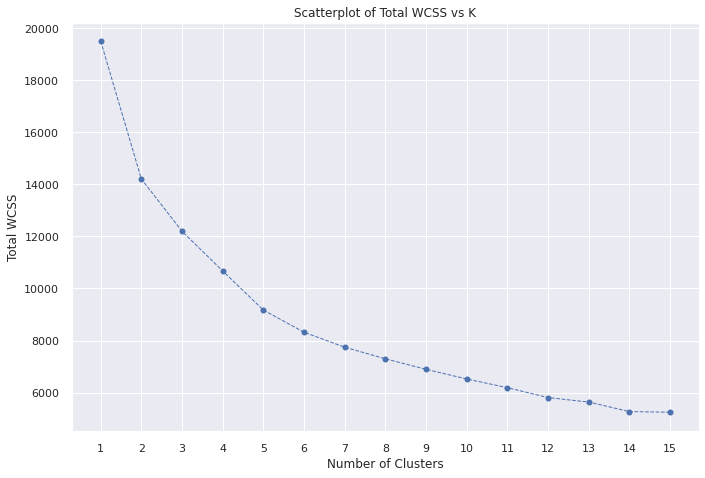

In [ ]:
sns.set(font_scale = 1)
plt.figure(figsize=(10, 7)) 
plt.plot(range(1, max_k+1), wcss,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(1, max_k+1))
plt.title('Scatterplot of Total WCSS vs K')
plt.xlabel("Number of Clusters")
plt.ylabel("Total WCSS")
plt.show()

In [ ]:
kl = KneeLocator(range(1, max_k+1), wcss, curve="convex", direction="decreasing")

kl.elbow

#To locate the elbow point of the curve using kneed package

5

In [ ]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients0 = []

# Start at 2 clusters for silhouette coefficient
for k in range(2, max_k):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(kmeanstransfinal_scaled)
    score = silhouette_score(kmeanstransfinal_scaled, kmeans.labels_,metric = 'euclidean')
    silhouette_coefficients0.append(score)

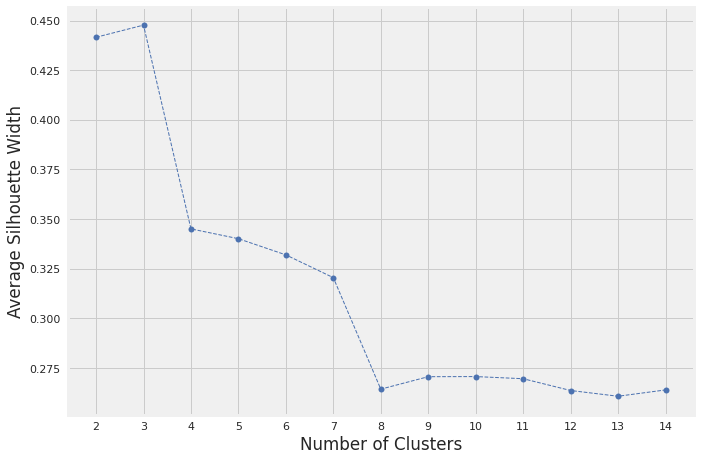

In [ ]:
plt.figure(figsize=(10, 7)) 
plt.style.use("fivethirtyeight")
plt.plot(range(2, max_k), silhouette_coefficients0,linestyle='--', marker='o', color='b',linewidth=1)
plt.xticks(range(2, max_k))
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Width")
plt.show()

In [ ]:
kmeans_transfinal_scaled = KMeans(init="random",n_clusters=5, n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal_scaled.fit(kmeanstransfinal_scaled)
clustergroups_transfinal_scaled = kmeans_transfinal_scaled.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal_scaled = pd.DataFrame(kmeans_transfinal_scaled.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal_scaled.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal_scaled.index.name = "Clusters"

In [ ]:
test3 = pd.Series(clustergroups_transfinal_scaled)
test3.value_counts()

4    1425
1    1009
0     284
3      49
2      20
dtype: int64

In [ ]:
Clustercenters_transfinal_scaled

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,1.196391,-0.108342,1.656883,1.322567,1.708782,1.716258,0.000040
1,0.213659,-0.125272,0.283363,0.353187,0.341149,0.307459,0.016814
2,3.846339,-0.103404,2.135864,1.280971,1.353463,1.885257,8.763087
3,0.127853,6.452023,0.368134,1.322462,0.274830,0.150788,-0.017318
4,-0.448104,-0.110114,-0.573491,-0.577119,-0.610561,-0.591395,-0.134309


<a id='actionable'></a>

### K-Means Clustering with K=3 for Scaled Data


In [ ]:
kmeans_transfinal_scaled = KMeans(init="random",n_clusters=3, n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal_scaled.fit(kmeanstransfinal_scaled)
clustergroups_transfinal_scaled = kmeans_transfinal_scaled.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal_scaled = pd.DataFrame(kmeans_transfinal_scaled.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal_scaled.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal_scaled.index.name = "Clusters"

In [ ]:
test3 = pd.Series(clustergroups_transfinal_scaled)
test3.value_counts()

0    1975
1     762
2      50
dtype: int64

In [ ]:
Clustercenters_transfinal_scaled

# Cluster 0: Customers who hardly spend on any product?
# Cluster 1: Customers who spend on Packaged Food, Cooking Essentials, Staple Goods, Beverages and Baking and Spreads. These are customers who love convenience.
# Cluster 2: Customers who purchase mainly baby care and staple goods products from the retail outlet. Here for only basic needs.

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,-0.309772,-0.113884,-0.41123,-0.378813,-0.411797,-0.405664,-0.111915
1,0.793205,-0.124045,1.04037,0.895351,1.047594,1.040046,0.290883
2,0.125497,6.389049,0.35932,1.292491,0.271451,0.144510,-0.020469


### K-Means Clustering with K=4 for Scaled Data

In [ ]:
kmeans_transfinal_scaled = KMeans(init="random",n_clusters=4, n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal_scaled.fit(kmeanstransfinal_scaled)
clustergroups_transfinal_scaled = kmeans_transfinal_scaled.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal_scaled = pd.DataFrame(kmeans_transfinal_scaled.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal_scaled.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal_scaled.index.name = "Clusters"

In [ ]:
test3 = pd.Series(clustergroups_transfinal_scaled)
test3.value_counts()

1    1486
0    1019
3     232
2      50
dtype: int64

In [ ]:
Clustercenters_transfinal_scaled

# Cluster 0: Customers who spend on Packaged Food, Cooking Essentials, Staple Goods, Beverages and Baking and Spreads. These are customers who love convenience.
# But these customers spend an average amount on these goods. 
# Cluster 1: Customers who hardly spend on any product?
# Cluster 2: Customers who purchase mainly baby care and staple goods products from the retail outlet. Here for only basic needs.
# Cluster 3: Customers who spend on Packaged Food, Cooking Essentials, Staple Goods, Beverages and Baking and Spreads. These are customers who love convenience.
# But these customers spend a lot more than average on these goods. This could mean that they are best/loyal customers (or slightly above average).

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,0.241438,-0.128215,0.355385,0.414660,0.431604,0.394496,0.035670
1,-0.430342,-0.109253,-0.555480,-0.555927,-0.592217,-0.574770,-0.127647
2,0.125497,6.389049,0.359320,1.292491,0.271451,0.144510,-0.020469
3,1.666021,-0.113934,1.915643,1.456784,1.834626,1.913457,0.664637


### K-Means Clustering with K=6 for Scaled Data

In [ ]:
kmeans_transfinal_scaled = KMeans(init="random",n_clusters=6, n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal_scaled.fit(kmeanstransfinal_scaled)
clustergroups_transfinal_scaled = kmeans_transfinal_scaled.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal_scaled = pd.DataFrame(kmeans_transfinal_scaled.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal_scaled.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal_scaled.index.name = "Clusters"

In [ ]:
test3 = pd.Series(clustergroups_transfinal_scaled)
test3.value_counts()

3    1359
1     988
4     337
0      49
2      44
5      10
dtype: int64

In [ ]:
Clustercenters_transfinal_scaled

# Cluster 0: Customers who purchase mainly baby care and staple goods products from the retail outlet. Here for only basic needs.
# Cluster 1: Customers who spend on Packaged Food, Cooking Essentials, Staple Goods, Beverages and Baking and Spreads. These are customers who love convenience.
# But these customers spend an average amount on these goods. 
# Cluster 2: Customers who are here for mainly more "exotic" other products such as Bird Nest / Chicken Essence.
# Cluster 3: Customers who hardly spend on any product?
# Cluster 4: Customers who spend on Packaged Food, Cooking Essentials, Staple Goods, Beverages and Baking and Spreads. These are customers who love convenience.
# But these customers spend slightly above average on these goods. Slightly above average tier. 
# Cluster 5: Customers who spend on Packaged Food, Cooking Essentials, Staple Goods, Beverages and Baking and Spreads.
# But they are also willing to go out of their way to purchase Other Products as well.
# This could mean that they are best/loyal customers.

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,0.127853,6.452023,0.368134,1.322462,0.274830,0.150788,-0.017318
1,0.168547,-0.124251,0.205506,0.279679,0.276480,0.242298,-0.084598
2,0.617907,-0.140620,0.762036,0.783751,0.168512,0.275975,5.670316
3,-0.463368,-0.108369,-0.591610,-0.596944,-0.635879,-0.612490,-0.136417
4,1.019994,-0.117977,1.496845,1.193827,1.530499,1.550233,-0.071103
5,8.473817,-0.013827,4.335909,3.156477,5.251270,4.931327,4.418589


We ultimately decide to go with K = 5 since we can gather many insights out of these individual clusters.

### K-Means Clustering with K=5 for Scaled Data (Final)

In [ ]:
kmeans_transfinal_scaled = KMeans(init="random",n_clusters=5, n_init = 10, max_iter = 300, random_state = 42)
kmeans_transfinal_scaled.fit(kmeanstransfinal_scaled)
clustergroups_transfinal_scaled = kmeans_transfinal_scaled.labels_ #The cluster number for each row

In [ ]:
Clustercenters_transfinal_scaled = pd.DataFrame(kmeans_transfinal_scaled.cluster_centers_) #Dataframe of cluster centers
Clustercenters_transfinal_scaled.rename(columns={0:'Beverage', 1:'BabyCare', 2:'PackagedFood', 3:'StapleGoods', 4:'CookingEssentials', 5:'BakingAndSpreads', 6:'OtherProducts'},inplace=True)
Clustercenters_transfinal_scaled.index.name = "Clusters"

In [ ]:
test3 = pd.Series(clustergroups_transfinal_scaled)
test3.value_counts()

4    1425
1    1009
0     284
3      49
2      20
dtype: int64

In [ ]:
Clustercenters_transfinal_scaled

,Beverage,BabyCare,PackagedFood,StapleGoods,CookingEssentials,BakingAndSpreads,OtherProducts
Clusters,,,,,,,
0,1.196391,-0.108342,1.656883,1.322567,1.708782,1.716258,0.000040
1,0.213659,-0.125272,0.283363,0.353187,0.341149,0.307459,0.016814
2,3.846339,-0.103404,2.135864,1.280971,1.353463,1.885257,8.763087
3,0.127853,6.452023,0.368134,1.322462,0.274830,0.150788,-0.017318
4,-0.448104,-0.110114,-0.573491,-0.577119,-0.610561,-0.591395,-0.134309


Some initial observations:

* Cluster 0: Customers who loves convenience. Spends slightly above average of what the average consumer spends.
* Cluster 1: Similar to Cluster 0, but their spending is average.
* Cluster 2: Spends a high amount on Other Products and Beverages. These could be customers who purchase more expensive products for special occasions.
* Cluster 3: Customers who spend a significant amount on Baby Care Products on average.
* Cluster 4: Customers who love convenience, but spend below average on every product type. 

To target Clusters 0, 1 and 4 (customers who love convenience as they buy products of almost every Product Type off the retail markets), we can consider promoting some products by giving discounts/other free products, which we would elaborate about below. 

Also, Cluster 2 is a really small market with an acquired taste of Beverages and Other Products. Could the products being purchased be expensive such that their average spending on these Product Types are higher than the other clusters?


## Exploratory Data Analysis with 5 Clusters

In [ ]:
# For K = 5 clusters

def assign_income_cat(x):
    if ((x == "Income < 1500") or (x == "Income 1500 - 1999")):
        return "Low"
    elif ((x == "Income 2000 - 2999") or (x == "Income 3000 - 3999") or (x == "Income 4000 - 4999")):
        return "Average"
    else:
        return "High"

def assign_HH_cat(x):
    if (x == "1-3 Member HH"):
        return "Low"
    elif ((x == "4 Member HH") or (x == "5 Member HH")):
        return "Average"
    else:
        return "High"

demo_abs = demographics.copy()
demo_abs = demo_abs[demo_abs['Panel ID'].isin(transactions_clean['Panel ID'])]
demo_abs['Cluster'] = clustergroups_transfinal_scaled
demo_abs = demo_abs.reset_index()
demo_abs.drop('index', axis = 1, inplace=True)
demo_abs["#HH"] = demo_abs["#HH"].apply(lambda x: assign_HH_cat(x)) #assign value
demo_abs['#HH'] = pd.Categorical(demo_abs['#HH'], 
                      categories=["Low", "Average", "High"],
                      ordered=True)
demo_abs["Income"] = demo_abs["Income"].apply(lambda x: assign_income_cat(x)) #assign value
demo_abs['Income'] = pd.Categorical(demo_abs['Income'], 
                      categories=["Low", "Average", "High"],
                      ordered=True)

demo_abs

,Panel ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Cluster
0,Panel 101011101,Obese,Low,Malay,Empty Nesters,Urban,Low,North,1
1,Panel 101016101,Healthy,Low,Malay,Teens Aches,Urban,Low,North,4
2,Panel 101019101,Obese,Low,Malay,Teens Aches,Urban,Average,North,1
3,Panel 101024101,Over Weight,Low,Chinese,Nesting Families,Urban,Low,North,1
4,Panel 105009103,Over Weight,Low,Malay,Empty Nesters,Rural,Low,North,1
...,...,...,...,...,...,...,...,...,...
2782,Panel 801900701,Healthy,High,Others,Yankys,Urban,Low,Central,4
2783,Panel 801901201,Over Weight,High,Malay,Teens and Toddlers,Urban,High,Central,4
2784,Panel 801903201,Obese,Average,Malay,Teens and Toddlers,Urban,High,Central,4
2785,Panel 801903801,Healthy,Low,Malay,Yankys,Urban,Low,Central,4


In [ ]:
# demo_abs.groupby(['Income', '#HH', 'Cluster']).count()['Panel ID'].unstack().fillna(0)

In [ ]:
nominated = ['Panel 201204101', 'Panel 205002101', 'Panel 206077101', 'Panel 207035101', 'Panel 209066101', 'Panel 209070101',
             'Panel 211043101', 'Panel 211096101', 'Panel 214048101', 'Panel 225150101', 'Panel 240033101', 'Panel 801498301',
             'Panel 801643401', 'Panel 801880801']
demo_abs[demo_abs['Panel ID'] == 'Panel 214048101']

,Panel ID,BMI,Income,Ethnicity,Lifestage,Strata,#HH,location,Cluster
728,Panel 214048101,Healthy,High,Malay,Teens and Toddlers,Urban,High,Central,0


In [ ]:
demo_abs.groupby(['#HH', 'Cluster']).count()['Panel ID'].unstack().fillna(0)

Cluster,0,1,2,3,4
#HH,,,,,
Low,58,287,11,6,454
Average,126,469,8,24,612
High,100,253,1,19,359


In [ ]:
demo_abs.groupby(['Income', 'Cluster']).count()['Panel ID'].unstack().fillna(0)

Cluster,0,1,2,3,4
Income,,,,,
Low,59,282,1,9,416
Average,147,462,7,21,672
High,78,265,12,19,337


Cluster 3 spends significantly more on Baby Care products than other clusters (though we should note that Cluster 3 is significantly smaller than other clusters).

The other clusters contain a significant amount of customers who are either in Nesting Families or in families with Teens and Toddlers.
* Cluster 0: 43.3% 
* Cluster 1: 37.0%
* Cluster 2: 20.0%
* Cluster 3: 93.9%
* Cluster 4: 49.7%

A sizeable proportion of customers in the biggest Clusters (0, 1 and 4) are either in Nesting Families or in families with Teens and Toddlers.
Cluster 3 is significantly smaller than these 3 clusters. Therefore, more should be done to promote Baby Care products to these significantly bigger clusters.

Next, we take a look at Cluster 2, where the customers had spent significantly more on Other Products and Beverages than other clusters. Could it be because they had bought high-priced items such as Beer / Spirits, and Chicken Essence / Bird Nest?

We can investigate this by looking at the Average Spend per Product (be it a Beverage or Other Products).

In [ ]:
cluster0_IDs = demo_abs[demo_abs['Cluster'] == 0]['Panel ID']
cluster0_spend = transactions_clean[transactions_clean['Panel ID'].isin(cluster0_IDs)].groupby('Category').sum().reset_index()
cluster0_spend = cluster0_spend[['Category', 'Spend']].merge(categories[['Category', 'Product Type']], how = 'left', on = 'Category')
cluster0_spend['Average Spend'] = cluster0_spend['Spend'] / cluster0_IDs.size
#cluster0_spend[cluster0_spend['Product Type'].isin(['Staple Goods', 'Cooking Essentials'])].sort_values(by = 'Average Spend', ascending = False)
cluster0_spend[cluster0_spend['Product Type'].isin(['Beverages', 'Other Products'])].sort_values(by = 'Average Spend', ascending = False)

,Category,Spend,Product Type,Average Spend
58,Tonic Food Drink,99823.8,Beverages,351.492254
17,Coffee,72200.2,Beverages,254.226056
1,Beer,33939.2,Beverages,119.504225
22,Cordials,26284.2,Beverages,92.550000
57,Tea,26012.2,Beverages,91.592254
24,Cultured Milk,21743.0,Beverages,76.559859
7,CSD,16151.2,Beverages,56.870423
30,Fruit/Veg Juices,15411.9,Beverages,54.267254
36,Isotonic Drinks,14902.9,Beverages,52.475000
25,Drinking Water,10555.0,Beverages,37.165493


In [ ]:
cluster1_IDs = demo_abs[demo_abs['Cluster'] == 1]['Panel ID']
cluster1_spend = transactions_clean[transactions_clean['Panel ID'].isin(cluster1_IDs)].groupby('Category').sum().reset_index()
cluster1_spend = cluster1_spend[['Category', 'Spend']].merge(categories[['Category', 'Product Type']], how = 'left', on = 'Category')
cluster1_spend['Average Spend'] = cluster1_spend['Spend'] / cluster1_IDs.size
cluster1_spend[cluster1_spend['Product Type'].isin(['Beverages', 'Other Products'])].sort_values(by = 'Average Spend', ascending = False)

,Category,Spend,Product Type,Average Spend
58,Tonic Food Drink,218165.8,Beverages,216.219822
17,Coffee,134187.2,Beverages,132.990287
57,Tea,47090.7,Beverages,46.670664
22,Cordials,40036.6,Beverages,39.679485
1,Beer,37891.5,Beverages,37.553518
36,Isotonic Drinks,33450.6,Beverages,33.152230
24,Cultured Milk,31935.5,Beverages,31.650644
30,Fruit/Veg Juices,25939.1,Beverages,25.707730
7,CSD,22477.4,Beverages,22.276908
25,Drinking Water,13916.7,Beverages,13.792567


In [ ]:
cluster2_IDs = demo_abs[demo_abs['Cluster'] == 2]['Panel ID']
cluster2_spend = transactions_clean[transactions_clean['Panel ID'].isin(cluster2_IDs)].groupby('Category').sum().reset_index()
cluster2_spend = cluster2_spend[['Category', 'Spend']].merge(categories[['Category', 'Product Type']], how = 'left', on = 'Category')
cluster2_spend['Average Spend'] = cluster2_spend['Spend'] / cluster2_IDs.size
cluster2_spend[cluster2_spend['Product Type'].isin(['Beverages', 'Other Products'])].sort_values(by = 'Average Spend', ascending = False)

,Category,Spend,Product Type,Average Spend
1,Beer,20588.6,Beverages,1029.430
55,Spirits,11330.2,Beverages,566.510
13,Chicken Essence,8719.8,Other Products,435.990
17,Coffee,7289.3,Beverages,364.465
3,Bird Nest,6229.8,Other Products,311.490
58,Tonic Food Drink,5879.1,Beverages,293.955
59,Wine,2647.3,Beverages,132.365
36,Isotonic Drinks,2562.0,Beverages,128.100
57,Tea,2365.5,Beverages,118.275
30,Fruit/Veg Juices,2249.3,Beverages,112.465


In [ ]:
cluster3_IDs = demo_abs[demo_abs['Cluster'] == 3]['Panel ID']
cluster3_spend = transactions_clean[transactions_clean['Panel ID'].isin(cluster3_IDs)].groupby('Category').sum().reset_index()
cluster3_spend = cluster3_spend[['Category', 'Spend']].merge(categories[['Category', 'Product Type']], how = 'left', on = 'Category')
cluster3_spend['Average Spend'] = cluster3_spend['Spend'] / cluster3_IDs.size
cluster3_spend[cluster3_spend['Product Type'].isin(['Beverages', 'Other Products'])].sort_values(by = 'Average Spend', ascending = False)

,Category,Spend,Product Type,Average Spend
56,Tonic Food Drink,9711.0,Beverages,198.183673
16,Coffee,4352.3,Beverages,88.822449
23,Cultured Milk,2505.7,Beverages,51.136735
21,Cordials,2396.5,Beverages,48.908163
55,Tea,2233.2,Beverages,45.575510
29,Fruit/Veg Juices,1412.4,Beverages,28.824490
6,CSD,1100.7,Beverages,22.463265
35,Isotonic Drinks,1021.2,Beverages,20.840816
52,Soy Milk,803.4,Beverages,16.395918
58,Yoghurt Drink,775.3,Beverages,15.822449


In [ ]:
cluster4_IDs = demo_abs[demo_abs['Cluster'] == 4]['Panel ID']
cluster4_spend = transactions_clean[transactions_clean['Panel ID'].isin(cluster4_IDs)].groupby('Category').sum().reset_index()
cluster4_spend = cluster4_spend[['Category', 'Spend']].merge(categories[['Category', 'Product Type']], how = 'left', on = 'Category')
cluster4_spend['Average Spend'] = cluster4_spend['Spend'] / cluster4_IDs.size
cluster4_spend[cluster4_spend['Product Type'].isin(['Beverages', 'Other Products'])].sort_values(by = 'Average Spend', ascending = False)

,Category,Spend,Product Type,Average Spend
58,Tonic Food Drink,90401.8,Beverages,63.439860
17,Coffee,56136.2,Beverages,39.393825
57,Tea,20374.3,Beverages,14.297754
22,Cordials,16059.3,Beverages,11.269684
24,Cultured Milk,16004.6,Beverages,11.231298
36,Isotonic Drinks,13118.5,Beverages,9.205965
25,Drinking Water,10427.4,Beverages,7.317474
1,Beer,10105.6,Beverages,7.091649
7,CSD,9051.1,Beverages,6.351649
30,Fruit/Veg Juices,8983.4,Beverages,6.304140


In [ ]:
clusters_spend = [cluster0_spend[['Category', 'Average Spend']], cluster1_spend[['Category', 'Average Spend']], cluster2_spend[['Category', 'Average Spend']], cluster3_spend[['Category', 'Average Spend']], cluster4_spend[['Category', 'Average Spend']]]
clusters_avgSpend = reduce(lambda  left,right: pd.merge(left,right,on='Category',
                                            how='left'), clusters_spend)
clusters_avgSpend.columns = ['Category', 'AvgSpend0', 'AvgSpend1', 'AvgSpend2', 'AvgSpend3', 'AvgSpend4']
clusters_avgSpend.fillna(0, inplace=True)
clusters_avgSpend[clusters_avgSpend['Category'].isin(['Bird Nest', 'Wine', 'Chicken Essence', 'Spirits', 'Beer'])].reset_index().drop(columns='index')

,Category,AvgSpend0,AvgSpend1,AvgSpend2,AvgSpend3,AvgSpend4
0,Beer,119.504225,37.553518,1029.430,14.467347,7.091649
1,Bird Nest,2.463380,3.706640,311.490,0.000000,1.047649
2,Chicken Essence,12.163732,12.323290,435.990,13.175510,2.343930
3,Spirits,24.504225,4.007929,566.510,0.000000,0.115368
4,Wine,34.605986,3.314073,132.365,9.748980,0.460772


In [ ]:
demo_abs[demo_abs['Cluster'] == 2]['Ethnicity'].value_counts()

Chinese    16
Malay       2
Others      2
Name: Ethnicity, dtype: int64

From here, we can tell that Cluster 2 has a significantly higher average spending on expensive products such as Wine, Bird Nest, Chicken Essence, Spirits and Beer. But majority of the people in Cluster 2 are Chinese; Muslims cannot consume alcoholic drinks due to their religion. This might explain the huge spending on Beer and Spirits in Cluster 2.


## Actionable Insights

Using the insights we have gathered above, we design our actionable insights into three packages as explained:

### Package 1 - The Daily Essentials Package



In order to entice customers from Cluster 0 to purchase more Cooking Essentials and Staple Goods, the Daily Essentials Package could be introduced. As customers from Cluster 0 tend to purchase Cooking Essentials and Staple Goods together more often than the other customers, introducing packages like this provides discounts and at the same time convenience. Thus, they would then be more inclined to purchase more, generating more revenue in the process.

The Daily Essentials Package, which includes a carton of 10 eggs, Milk Powder (either Kids or Adults) and a bottle of cooking oil, could be sold at the price of 2 Milk Powder packets. 


In [ ]:
# Get all transactions in Cluster 0
cluster0_transactions = transactions_clean[transactions_clean['Panel ID'].isin(cluster0_IDs)]
cluster0_transactions

,Panel ID,Date,Category,Pack Size,Volume,Spend
5703,Panel 105021106,2018-06-17,Cooking Oils,2,2.0,5.0
5704,Panel 105021106,2018-06-17,Rice,1,10.0,24.9
5705,Panel 105021106,2018-06-17,Sugar,2,2.0,5.8
5706,Panel 105021106,2018-06-17,Coffee,2,0.6,9.0
5707,Panel 105021106,2018-06-17,Eggs,1,30.0,9.9
...,...,...,...,...,...,...
1313271,Panel 801822301,2020-06-14,Cooking Sauces,1,0.3,3.3
1313272,Panel 801822301,2020-06-14,Beer,7,2.2,41.9
1313273,Panel 801822301,2020-06-14,Eggs,1,10.0,3.7
1313274,Panel 801822301,2020-06-14,Beer,36,11.5,215.6


In [ ]:
# Check how many customers in cluster 0 have purchased 'Milk Powder-Kids' before
cluster0_transactions[cluster0_transactions['Category'] == 'Milk Powder-Kids']['Panel ID'].nunique()

103

In [ ]:
# Check how many customers in cluster 0 have purchased 'Milk Powder-Adult' before
cluster0_transactions[cluster0_transactions['Category'] == 'Milk Powder-Adult']['Panel ID'].nunique()

198

### Package 2 - The Exquisite Taste Buds Package

In order to entice customers from Cluster 2 to purchase more Beverages and Other Products, the Exquisite Taste Buds Package could be introduced. As customers from Cluster 2 tend to purchase Beverages and Other Products together more often than the other customers, introducing packages like this provides discounts and at the same time convenience. Thus, they would then be more inclined to purchase more, generating more revenue in the process.

As such, the Exquisite Taste Buds Package, which includes 2 bottles of Beer, either Chicken Essence or Bird Nest, could be sold at the price of 2 Spirits.


In [ ]:
categories[categories['Category'].isin(['Beer', 'Chicken Essence', 'Bird Nest'])]
# categories[categories['Product Type'].isin(['Beverages'])].sort_values(by = 'Price per Volume', ascending = False)

,Category,Calories/100g,Price per Volume,Product Type
1,Beer,43,15.12,Beverages
3,Bird Nest,46,73.45,Other Products
12,Chicken Essence,267,76.54,Other Products


In [ ]:
# Get all transactions in Cluster 2
cluster2_transactions = transactions_clean[transactions_clean['Panel ID'].isin(cluster2_IDs)]
cluster2_transactions

,Panel ID,Date,Category,Pack Size,Volume,Spend
20242,Panel 106061101,2018-06-17,Canned Product,1,0.3,4.0
20243,Panel 106061101,2018-06-17,Snack,1,0.2,3.4
20244,Panel 106061101,2018-06-17,Biscuits,1,0.1,1.0
20245,Panel 106061101,2018-06-17,Isotonic Drinks,1,1.5,2.6
20246,Panel 106061101,2018-06-17,Snack,1,0.2,2.8
...,...,...,...,...,...,...
1305503,Panel 801792301,2020-05-31,Bouilon,1,0.3,6.5
1305504,Panel 801792301,2020-06-07,Bird Nest,20,1.4,108.0
1305505,Panel 801792301,2020-06-07,Soy Milk,1,1.0,5.8
1305506,Panel 801792301,2020-06-07,Liquid Milk,1,1.0,5.4


In [ ]:
# Check how many customers in cluster 2 have purchased 'Bird Nest' before
cluster2_transactions[cluster2_transactions['Category'] == 'Bird Nest']['Panel ID'].nunique()

12

In [ ]:
# Check how many customers in cluster 2 have purchased 'Bird Nest' before
cluster2_transactions[cluster2_transactions['Category'] == 'Chicken Essence']['Panel ID'].nunique()

17

### Package 3 - The Family Starter Package

In order to entice customers from Cluster 3 to purchase more Baby Care products, the Family Starter Package could be introduced. As customers from Cluster 3 tend to purchase Baby Care products more often than the other customers, introducing packages like this provides discounts and at the same time convenience. Thus, they would then be more inclined to purchase more, generating more revenue in the process. 

As such, the Family Starter Package, which includes a carton of 2 Milk Powder packets for Infants, and a Baby Cereal, could be sold at the price of 2 Milk Powder packets for Infants.

In [ ]:
categories[categories['Category'].isin(['Baby Cereal', 'Milk Powder-Infant'])]

,Category,Calories/100g,Price per Volume,Product Type
0,Baby Cereal,188,29.41,Baby Care
42,Milk Powder-Infant,450,45.77,Baby Care


In [ ]:
# Get all transactions in Cluster 3
cluster3_transactions = transactions_clean[transactions_clean['Panel ID'].isin(cluster3_IDs)]
cluster3_transactions

,Panel ID,Date,Category,Pack Size,Volume,Spend
21802,Panel 106077101,2018-06-24,Milk Powder-Kids,2,1.2,57.0
21803,Panel 106077101,2018-06-24,Rice,1,5.0,15.0
21804,Panel 106077101,2018-06-24,Sugar,2,2.0,5.9
21805,Panel 106077101,2018-06-24,Ice Cream,1,1.5,6.0
21806,Panel 106077101,2018-06-24,Tonic Food Drink,1,2.0,40.0
...,...,...,...,...,...,...
1312146,Panel 801815001,2020-05-10,Milk Powder-Infant,1,1.3,123.0
1312147,Panel 801815001,2020-05-24,Milk Powder-Infant,1,1.3,123.0
1312148,Panel 801815001,2020-05-31,Milk Powder-Infant,1,1.3,123.0
1312149,Panel 801815001,2020-06-07,Milk Powder-Infant,1,0.6,63.9


In [ ]:
# Check how many customers in cluster 3 have purchased 'Milk Powder-Infant' before
cluster3_transactions[cluster3_transactions['Category'] == 'Milk Powder-Infant']['Panel ID'].nunique()

49

In [ ]:
# Check how many customers in cluster 3 have purchased 'Baby Cereal' before
cluster3_transactions[cluster3_transactions['Category'] == 'Baby Cereal']['Panel ID'].nunique()

31